### Diagnosing Pneumonia using Chest X-Ray Images

I use [Kaggle's](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) data of chest x-ray images to diagnose pneumonia using a convolutional neural network. The dataset is organised into 3 subfolders (train, test, val) where each subfolder contains two subfolders for the two categories (pneumonia/normal). There are 5638 X-Ray JPEG images and two categories, pneumonia or normal. 

Detecting pneumonia using x-ray images is a simple binary classifcation problem, where 0 represents normal and 1 represents pneumonia. I implement a neural network with five hidden convolutional layers followed by a fully connected layer.

The model was tested on a 100 test x-ray images and had an accuracy of 84.48%.

In [1]:
# importing general libraries
import numpy as np
from PIL import Image
from skimage.transform import resize
from random import randrange
import os, pickle, json, glob
import matplotlib.pyplot as plt

# importing deep learning libraries
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

I define a normalize() function that normalizes an image to [0, 1] range. I then define a process_imgs() function, which returns the generators for the training and validation data, as well as returning the testing data and its labels.

The process_imgs() functions takes the arguements xDimension, yDimension, which resizes the images into a xDimension x yDimension images. The batchSize controls the batch size for the generator. The training data is augmented to create variability. It is randomly rotated anywhere from 0 to 40 degrees and zoomed by anywhere from 75% to 125%. It is also randomly vertically flipped.

In [2]:
# normalize array to [0, 1] range
def normalize(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

# creates generators for the images as well as test images
path = '/home/moe/Projects/Kaggle/X-Ray/chest_xray'
def process_imgs(xDimension, yDimension, batchSize):
    train_generator_object = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                                zoom_range = 0.25, vertical_flip=True)
    val_generator_object = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_generator_object.flow_from_directory(
        directory=path+'/train',
        target_size=(xDimension, yDimension),
        color_mode='grayscale',
        batch_size=batchSize,
        class_mode='binary',
        shuffle=True)
    
    val_gen = val_generator_object.flow_from_directory(
        directory=path+'/val',
        target_size=(xDimension, yDimension),
        color_mode='grayscale',
        batch_size=batchSize,
        class_mode='binary',
        shuffle=True)
    
    # setup test images to test model performance
    test_data = []
    test_labels = []
    for health in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path + '/test' + health)):
            img = plt.imread(path + '/test'+ health + img)
            img = resize(img, (xDimension, yDimension))
            #img = np.dstack([img, img, img])
            img = normalize(img.astype('float32'))
            if health=='/NORMAL/':
                label = 0
            elif health=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    return train_gen, val_gen, test_data, test_labels

In [3]:
# set model hyperparameters
xDimension, yDimension = 200, 200
epochs = 50
batchSize = 64

train_gen, val_gen, test_data, test_labels = process_imgs(xDimension, yDimension, batchSize)

Found 5116 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


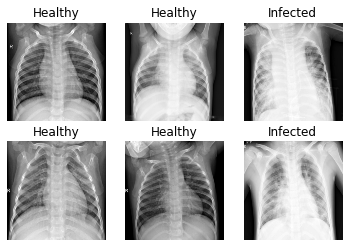

In [4]:
# plotting some of the x-ray images for healthy and infected patients
for i in range(6):
    ind = randrange(len(test_labels))
    plt.subplot(2, 3, i+1)
    plt.imshow(test_data[ind,:], cmap='gray')
    if test_labels[ind]==0:
        plt.title('Healthy')
    else:
        plt.title('Infected')
    plt.axis('off')

In [7]:
# model creation 

model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(xDimension, yDimension, 1),
                 padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', dilation_rate=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', learning_rate=0.0001, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, mode='min')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 200, 200, 16)      2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 50, 50, 64)       

In [8]:
# model training
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batchSize, 
           epochs=epochs, validation_data=val_gen, 
           validation_steps=val_gen.samples // batchSize, callbacks=[lr_reduce, checkpoint])

Epoch 1/50
79/79 [==============================] - 59s 744ms/step - loss: 0.5844 - accuracy: 0.7452 - val_loss: 0.6952 - val_accuracy: 0.6441
Epoch 2/50
79/79 [==============================] - 54s 682ms/step - loss: 0.5700 - accuracy: 0.7468 - val_loss: 0.6658 - val_accuracy: 0.6441
Epoch 3/50
78/79 [============================>.] - ETA: 0s - loss: 0.5710 - accuracy: 0.7454
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
79/79 [==============================] - 54s 682ms/step - loss: 0.5712 - accuracy: 0.7452 - val_loss: 0.6855 - val_accuracy: 0.6441
Epoch 4/50
79/79 [==============================] - 51s 650ms/step - loss: 0.5647 - accuracy: 0.7502 - val_loss: 0.6661 - val_accuracy: 0.6441
Epoch 5/50
79/79 [==============================] - 52s 658ms/step - loss: 0.5205 - accuracy: 0.7577 - val_loss: 0.8915 - val_accuracy: 0.6458
Epoch 6/50
79/79 [==============================] - 52s 664ms/step - loss: 0.4509 - accuracy: 0.7817 - val_loss: 0.8668 - 

In [9]:
# saving model and training history
model.save('my_model.h5')

history_dict = hist.history
f = open('history.pckl', 'wb')
pickle.dump(history_dict, f)
f.close()

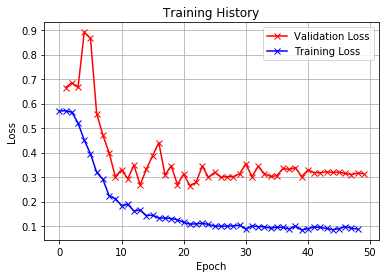

In [10]:
# plotting training history
f = open('history.pckl', 'rb')
history = pickle.load(f)
f.close()

train_loss = history['loss']
val_loss = history['val_loss']

x = np.arange(len(val_loss))

plt.plot(x[1:], val_loss[1:], 'rx-', train_loss[1:], 'bx-')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Validation Loss', 'Training Loss'])
plt.grid()
plt.show()


In [13]:
# testing model accuracy
model = load_model('my_model.h5')
X = test_data
Y = test_labels
Y_predicted = model.predict(np.expand_dims(X, axis=3))
accuracy = round((1 - (np.sum(np.absolute(np.round(Y - Y_predicted[:,0])))/len(Y)))*100, 2)

print('accuracy: '+str(accuracy) +'%')

accuracy: 84.48%
